In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import json
import anndata as ad
sys.path.append("..")
from src import *

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests, fdrcorrection

2024-08-13 11:16:54.817107: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 11:16:54.830688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 11:16:54.847310: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 11:16:54.852230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 11:16:54.864522: I tensorflow/core/platform/cpu_feature_guar

In [3]:
blue = sns.color_palette("colorblind")[0]
pink = sns.color_palette("colorblind")[4] 

In [4]:
config_path = "/data_nfs/je30bery/melanoma_data/config.json"
with open(config_path, "r") as f:
    config = json.load(f)
cell_types_path = config["cell_types"]
roi_path = config["PFS_ROIs"]

In [5]:
with open(config["antibody_gene_mapping"], "rb") as f:
    antibody_gene_symbols = json.load(f)

In [6]:
anndata_file_path = os.path.join(config["anndata_file"])
x = get_expression_anndata(anndata_file_path)

In [7]:
data = get_data_csv(groups=["Melanoma"], high_quality_only=True, pfs=True, config_path=config_path)

In [8]:
# get df from anndata files
dfs = list()

for fov in x.keys():
    anndata = x[fov]    
    expression = pd.DataFrame(anndata.X, columns=anndata.var["gene_symbol"])
    expression["Sample"] = fov
    cell_types = list(anndata.obs["cell_type"])
    roi_cells = get_roi_cells(roi_path, fov)
    roi_info = np.zeros(len(expression))
    assert roi_cells[0] == 0 # background is always within the ROIs
    roi_info[roi_cells[1:] - 1] = 1
    roi_info = roi_info.astype(bool)
    assert len(cell_types) == len(roi_info) 
    assert len(cell_types) == len(expression)
    expression["cell_types"] = cell_types
    expression["in_roi"] = roi_info
    dfs.append(expression) 

df = pd.concat(dfs, ignore_index=True)
df = df.dropna(axis="columns")

In [9]:
cell_types = sorted(np.unique(df["cell_types"].values))
pal = sns.color_palette("hls", len(np.unique(cell_types)))
cell_type_colors = {ct: pal[i] for i, ct in enumerate(cell_types)}

In [10]:
df.drop(['HLA-B', 'HLA-C', 'HLA-DRB1', 'HLA-DRB5', 'NFX1', 'CD3E', 'CD3G', 'CD8B', "COL4A1"], axis=1, inplace=True)
df.rename({"NCR3LG1": "DLG4", "HLA-A": "HLA-ABC", "HLA-DRA": "HLA-DR", "CD8A": "CD8", "COL4A2": "COL4"}, axis=1, inplace=True)

In [11]:
data = data.set_index("Sample")
df["histo_id"] = df["Sample"].apply(lambda x: data.loc[x]["Histo ID"])
df["PFS < 5"] = df["Sample"].apply(lambda x: data.loc[x]["PFS < 5"])
#df.drop("fov", axis=1, inplace=True)

In [12]:
distris = list()
lens = list()
for fov in df["Sample"].unique():
    for roi in [0, 1]:
        subset = df[(df["Sample"] == fov) & (df["in_roi"] == roi)]
        type, count = np.unique(subset["cell_types"], return_counts=True)
        count = count.astype(float) / np.sum(count)
        distri = pd.DataFrame(count.reshape(1, len(count)), columns=list(type), index=[fov])
        distri["In ROI"] = roi
        distri["Sample"] = fov
        distri["PFS < 5"] = data.loc[fov]["PFS < 5"]
        distris.append(distri)

In [13]:
distri_df = pd.concat(distris)
distri_df = distri_df.fillna(0)

In [14]:
subset_distri = distri_df[distri_df["In ROI"] == 1]
pvals = list()
cell_types = list()
for cell_type in sorted(subset_distri.columns[:11]):
    res = mannwhitneyu(subset_distri[subset_distri["PFS < 5"] == False][cell_type], 
                       subset_distri[subset_distri["PFS < 5"]== True][cell_type], alternative='two-sided')
    pvals.append(res.pvalue)
    cell_types.append(cell_type)
pvals = np.array(pvals)
_, adj_pvals, _, _ = multipletests(pvals, method='fdr_bh')
in_pfs0_vs_pfs1_pvals = zip(cell_types, adj_pvals)

In [15]:
distri_melted = pd.melt(distri_df, id_vars=["In ROI", "Sample", "PFS < 5"], var_name="Cell type", value_name="Cell type fraction")

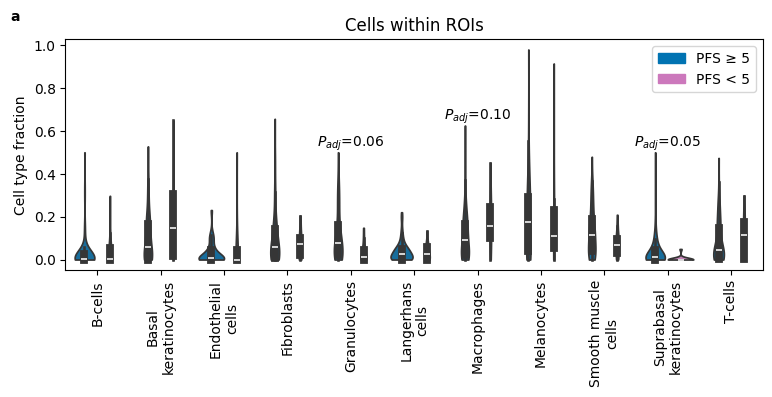

In [16]:
alpha = 0.1

f, ax = plt.subplots(1, figsize=(9, 3), sharex=True, sharey=True)
######
#ax = axs[0]
palette = {0: blue, 1: pink}
sns.violinplot(distri_melted[distri_melted["In ROI"] == 1], x="Cell type", y="Cell type fraction", hue="PFS < 5", ax=ax, palette=palette, cut=0, hue_order=[0,1])
ax.set_title("Cells within ROIs")
ax.set_xlabel(None)

for i, (cell_type, pval) in enumerate(in_pfs0_vs_pfs1_pvals):
    if pval < alpha:
        y = np.max(distri_df[cell_type])
        ax.text(i, y, f"$P_{{adj}}$={(pval):.2f}", ha='center', va='bottom')
        
#ax.text(-0.3, 0.7, "a", ha='center', va='bottom', weight="bold")

palette = {"PFS ≥ 5": blue, "PFS < 5": pink}
legend_handles = [Patch(color=color, label=key) for key, color in palette.items()]
ax.legend(handles=legend_handles, frameon=True)
ax.text(-1.3, 1.1, "a", ha='center', va='bottom', weight="bold")

tick_labels = [label.get_text().replace(" cells", "\ncells") for label in ax.get_xticklabels()]
tick_labels = [label.replace(" keratinocytes", "\nkeratinocytes") for label in tick_labels]  
ax.set_xticks(list(range(len(tick_labels))), tick_labels, rotation=90)
plt.savefig("../result_plots/celltype_distri_with_pvals.pdf", bbox_inches="tight")